#### GAN vs Ours [Minority Sample-size Sensitivity Study]

This notebook conducts a large-scale simulation comparing CTGAN, GAMO, MGVAE and our proposed MMD + Triplet oversampler over varying number of minority samples, using five standard classifiers and four evaluation metrics.

In [1]:
# %% [code]
# 1. Imports & Environment Setup
%matplotlib inline
import sys

sys.path.append("/home/oldrain123/IMBALANCED_CLASSIFICATION/MOMs")
sys.path.append('/home/oldrain123/IMBALANCED_CLASSIFICATION/')
sys.path.append('/home/oldrain123/IMBALANCED_CLASSIFICATION/SMOTE_variants/')

In [2]:
import os 
import random 
import logging 
from dataclasses import dataclass, asdict
from typing import Tuple, List, Dict

import numpy as np
import pandas as pd
import torch 
from tqdm.autonotebook import trange
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from moms_metrics import Metrics 
from moms_generate import transform
from moms_losses import MMD_est_torch 
from ctgan import CTGAN 
from gamosampler import GAMOtabularSampler
from mgvae import MGVAE

/tmp/ipykernel_958695/1761875700.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
logging.basicConfig(level=logging.WARNING, 
                    format='%(asctime)s - %(levelname)s - %(message)s')
print(f"Using device: {DEVICE}")

Using device: cuda


### Configuration

In [4]:
@dataclass
class Config:
    seed: int = 1203
    dim: int = 50
    n_maj: int = 2000
    n_mins: List[int] = (50, 100, 200, 500, 1000)
    n_sims: int = 10
    # test_per_class: int = 100
    n_epochs: int = 2000
    test_frac: float = 0.3

cfg = Config()
logging.info(f"Config: {asdict(cfg)}")

In [5]:
# Seed everything
random.seed(cfg.seed)
np.random.seed(cfg.seed)
if DEVICE != "cpu":
    torch.manual_seed(cfg.seed)

In [6]:
def create_dataset(
    dim: int, 
    n_maj: int,
    n_min: int, 
    shift: float = 0.3
    ) -> Tuple[np.ndarray, np.ndarray]:
    mu0 = np.zeros(dim); mu1 = np.ones(dim)*shift; cov = np.eye(dim)
    X0 = np.random.multivariate_normal(mu0, cov, n_maj)
    X1 = np.random.multivariate_normal(mu1, cov, n_min)
    X = np.vstack([X0, X1]); y = np.hstack([np.zeros(n_maj), np.ones(n_min)])
    return X, y

### 4. Classifier Definitions

In [7]:
CLASSIFIERS: Dict[str, object] = {
    'SVM': SVC(probability=True, random_state=cfg.seed),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=cfg.seed),
    'DecisionTree': DecisionTreeClassifier(random_state=cfg.seed),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=10000, random_state=cfg.seed),
    'kNN': KNeighborsClassifier()
}

### 5. Simulation & Evaluation Loop

In [8]:
X, y = create_dataset(cfg.dim, cfg.n_maj, n_min=100, shift = 0.3)

In [9]:
records = []
for n_min in trange(len(cfg.n_mins), desc="Minority Sample Size"):
    n_min = cfg.n_mins[n_min]
    for trial in trange(cfg.n_sims, desc=f"Trials @ n_min={n_min}", leave=False):
        # 5.1 Generate imbalanced dataset
        X, y = create_dataset(cfg.dim, cfg.n_maj, n_min, shift=0.3)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=cfg.test_frac, random_state=cfg.seed+trial)
        n_gen = int((y_train==0).sum() - (y_train==1).sum())

        # 5.2 CTGAN oversampling
        try:
            df_min = pd.DataFrame(X_train[y_train==1])
            df_min.columns = df_min.columns.astype(str)
            ctgan = CTGAN(epochs=cfg.n_epochs)
            ctgan.fit(df_min)
            X_syn_ct = ctgan.sample(n=n_gen)
        except Exception as e:
            logging.warning(f"CTGAN error: {e}")
            X_syn_ct = np.empty((0, cfg.dim))
        y_syn_ct = np.ones(len(X_syn_ct))

        # 5.3 Ours oversampling 
        try:
            _, _, X_syn_ours = transform(
                X_maj = X_train[y_train==0],
                X_min = X_train[y_train==1],
                in_dim = cfg.dim,
                latent_dim = max(1, cfg.dim*32),
                hidden_dims = [cfg.dim*2, cfg.dim*4, cfg.dim*8, cfg.dim*16],
                loss_fn = MMD_est_torch,
                kernel_type = 'gaussian',
                device = DEVICE,
                method = 'direct',
                n_epochs = cfg.n_epochs,
                lr = 1e-3*(n_min // 20),
                beta = 0.01,
                seed = cfg.seed+trial,
                residual=True
            )
        except Exception as e:
            logging.warning(f"Ours error: {e}")
            X_syn_ours = np.empty((0, cfg.dim))
        y_syn_ours = np.ones(len(X_syn_ours))

        # 5.4 GAMO oversampling
        try:
            X_maj = X_train[y_train==0]
            X_min = X_train[y_train==1]
            n_classes = 2
            class_counts = [len(X_maj), len(X_min)]
            all_minority_X = {0: X_maj, 1: X_min}
            gamo = GAMOtabularSampler(
                input_dim = X_min.shape[1],
                latent_dim = X_min.shape[1],
                all_minority_X = all_minority_X,
                n_classes = n_classes,
                class_counts = class_counts,
                class_emb_dim = X_min.shape[1] * 2,
                hidden_dim = X_min.shape[1] * 4,
                device = DEVICE
            )
            class_X_dict = {0: X_maj, 1: X_min}
            gamo.fit(class_X_dict, n_epochs = cfg.n_epochs)
            X_syn_gamo = gamo.sample(n_gen, class_id=1)
        except Exception as e:
            logging.warning(f"GAMO error: {e}")
            X_syn_gamo = np.empty((0, cfg.dim))
        y_syn_gamo = np.ones(len(X_syn_gamo))

        # 5.5 MGVAE oversampling 
        try:
            X_maj = X_train[y_train==0]
            X_min = X_train[y_train==1]
            mgvae = MGVAE(
                input_dim = X_maj.shape[1],
                latent_dim = max(1, cfg.dim*32),
                hidden_dims = [cfg.dim*2, cfg.dim*4, cfg.dim*8, cfg.dim*16],
                device = DEVICE,
                majority_subsample= 512
            )
            mgvae.pretrain(torch.tensor(X_maj, dtype=torch.float32).to(DEVICE),
                           epochs=cfg.n_epochs)
            pretrain_params = {n: p.clone().detach() for n, p in mgvae.named_parameters()}
            fisher = mgvae.compute_fisher(torch.tensor(X_maj, dtype=torch.float32).to(DEVICE))
            mgvae.finetune(
                torch.tensor(X_min, dtype=torch.float32).to(DEVICE),
                torch.tensor(X_maj, dtype=torch.float32).to(DEVICE),
                fisher, pretrain_params, epochs = cfg.n_epochs
            )
            X_syn_mgvae = mgvae.sample(torch.tensor(X_maj, dtype=torch.float32).to(DEVICE), n_gen)
            X_syn_mgvae = X_syn_mgvae.cpu().numpy()
        except Exception as e:
            logging.warning(f"MGVAE error: {e}")
            X_syn_mgvae = np.empty((0, cfg.dim))
        y_syn_mgvae = np.ones(len(X_syn_mgvae))

        # 5.6 Evaluation 
        for method, (X_syn, y_syn) in {
            'CTGAN':(X_syn_ct, y_syn_ct), 
            'Ours':(X_syn_ours, y_syn_ours),
            'GAMO':(X_syn_gamo, y_syn_gamo),
            'MGVAE':(X_syn_mgvae, y_syn_mgvae)
        }.items():
            X_aug = np.vstack([X_train, X_syn])
            y_aug = np.hstack([y_train, y_syn]) 
            for clf_name, clf in CLASSIFIERS.items():
                clf.fit(X_aug, y_aug)
                y_prob = clf.predict_proba(X_test)[:, 1]
                y_pred = (y_prob >= 0.5).astype(int) 

                m = Metrics(y_true=y_test, y_pred=y_pred, y_pred_prob=y_prob)
                res = m.all_metrics()
                res.update({
                    'n_min': n_min,
                    'trial': trial,
                    'method': method, 
                    'classifier': clf_name
                })
                records.append(res)
        print(pd.DataFrame(records))

Minority Sample Size:   0%|          | 0/5 [00:00<?, ?it/s]

Trials @ n_min=50:   0%|          | 0/10 [00:00<?, ?it/s]

/home/oldrain123/anaconda3/envs/imb_clf/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
2025-07-28 13:43:01,241 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


      G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0   0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1   0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2   0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3   0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4   0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
5   0.277120  0.133333  0.190152  0.876054  0.205957     50      0   Ours   
6   0.391580  0.235294  0.269355  0.862254  0.211547     50      0   Ours   
7   0.559517  0.076923  0.072774  0.599284  0.029445     50      0   Ours   
8   0.613441  0.322581  0.309797  0.897393  0.211596     50      0   Ours   
9   0.417635  0.049713  0.066678  0.641388  0.029477     50      0   Ours   
10  0.000000  0.000000  0.000000  0.869793  0.148308     50      0   GAMO   
11  0.000000  0.000000  0.000000  0.701955  0.041064     50      0   GAMO   

2025-07-28 14:02:15,422 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


      G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0   0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1   0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2   0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3   0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4   0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
5   0.277120  0.133333  0.190152  0.876054  0.205957     50      0   Ours   
6   0.391580  0.235294  0.269355  0.862254  0.211547     50      0   Ours   
7   0.559517  0.076923  0.072774  0.599284  0.029445     50      0   Ours   
8   0.613441  0.322581  0.309797  0.897393  0.211596     50      0   Ours   
9   0.417635  0.049713  0.066678  0.641388  0.029477     50      0   Ours   
10  0.000000  0.000000  0.000000  0.869793  0.148308     50      0   GAMO   
11  0.000000  0.000000  0.000000  0.701955  0.041064     50      0   GAMO   

2025-07-28 14:21:29,774 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


      G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0   0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1   0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2   0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3   0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4   0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
5   0.277120  0.133333  0.190152  0.876054  0.205957     50      0   Ours   
6   0.391580  0.235294  0.269355  0.862254  0.211547     50      0   Ours   
7   0.559517  0.076923  0.072774  0.599284  0.029445     50      0   Ours   
8   0.613441  0.322581  0.309797  0.897393  0.211596     50      0   Ours   
9   0.417635  0.049713  0.066678  0.641388  0.029477     50      0   Ours   
10  0.000000  0.000000  0.000000  0.869793  0.148308     50      0   GAMO   
11  0.000000  0.000000  0.000000  0.701955  0.041064     50      0   GAMO   

2025-07-28 14:40:43,013 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


      G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0   0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1   0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2   0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3   0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4   0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..       ...       ...       ...       ...       ...    ...    ...    ...   
75  0.405872  0.190476  0.178602  0.939469  0.267958     50      3  MGVAE   
76  0.000000  0.000000  0.000000  0.845771  0.120191     50      3  MGVAE   
77  0.489525  0.150000  0.138370  0.604270  0.041420     50      3  MGVAE   
78  0.406552  0.210526  0.206507  0.921504  0.298056     50      3  MGVAE   
79  0.000000  0.000000  0.000000  0.605100  0.042412     50      3  MGVAE   

      classifier  
0            SVM  
1   RandomForest  
2   DecisionTree  

2025-07-28 15:00:01,244 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


      G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0   0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1   0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2   0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3   0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4   0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..       ...       ...       ...       ...       ...    ...    ...    ...   
95  0.425695  0.266667  0.294320  0.929711  0.254206     50      4  MGVAE   
96  0.000000  0.000000  0.000000  0.693784  0.038327     50      4  MGVAE   
97  0.297491  0.071429  0.052078  0.532210  0.021608     50      4  MGVAE   
98  0.301262  0.153846  0.207776  0.817429  0.209614     50      4  MGVAE   
99  0.000000  0.000000  0.000000  0.475993  0.017886     50      4  MGVAE   

      classifier  
0            SVM  
1   RandomForest  
2   DecisionTree  

2025-07-28 15:19:15,766 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
115  0.249791  0.111111  0.170079  0.910684  0.316744     50      5  MGVAE   
116  0.000000  0.000000  0.000000  0.696369  0.073919     50      5  MGVAE   
117  0.000000  0.000000 -0.019917  0.492487  0.026016     50      5  MGVAE   
118  0.250000  0.117647  0.246927  0.852775  0.301645     50      5  MGVAE   
119  0.000000  0.000000  0.000000  0.571212  0.039888     50      5  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-28 15:38:05,309 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
135  0.408248  0.285714  0.404905  0.932698  0.423296     50      6  MGVAE   
136  0.000000  0.000000  0.000000  0.676686  0.072416     50      6  MGVAE   
137  0.000000  0.000000 -0.020730  0.489221  0.019512     50      6  MGVAE   
138  0.288436  0.142857  0.198423  0.914041  0.295825     50      6  MGVAE   
139  0.000000  0.000000  0.000000  0.566473  0.064871     50      6  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-28 15:57:26,376 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
155  0.377650  0.235294  0.302259  0.928512  0.324769     50      7  MGVAE   
156  0.000000  0.000000  0.000000  0.767233  0.060298     50      7  MGVAE   
157  0.370020  0.097561  0.073717  0.550630  0.030094     50      7  MGVAE   
158  0.000000  0.000000 -0.006159  0.861421  0.231468     50      7  MGVAE   
159  0.000000  0.000000  0.000000  0.548134  0.029036     50      7  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-28 16:15:50,826 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
175  0.432289  0.285714  0.326454  0.918301  0.394724     50      8  MGVAE   
176  0.000000  0.000000  0.000000  0.720054  0.066776     50      8  MGVAE   
177  0.246639  0.060606  0.034749  0.517894  0.028067     50      8  MGVAE   
178  0.432651  0.300000  0.367993  0.910789  0.370270     50      8  MGVAE   
179  0.000000  0.000000  0.000000  0.642894  0.092291     50      8  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-28 17:06:50,260 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
195  0.332775  0.181818  0.225962  0.881351  0.260979     50      9  MGVAE   
196  0.000000  0.000000  0.000000  0.682068  0.056828     50      9  MGVAE   
197  0.230916  0.046512  0.013106  0.507677  0.029864     50      9  MGVAE   
198  0.332775  0.181818  0.225962  0.812302  0.219379     50      9  MGVAE   
199  0.000000  0.000000  0.000000  0.566583  0.046129     50      9  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

Trials @ n_min=100:   0%|          | 0/10 [00:00<?, ?it/s]

2025-07-28 17:40:00,855 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
215  0.622962  0.486486  0.487392  0.957739  0.546028    100      0  MGVAE   
216  0.000000  0.000000  0.000000  0.810400  0.094228    100      0  MGVAE   
217  0.286006  0.065574  0.021781  0.513824  0.037910    100      0  MGVAE   
218  0.654474  0.476190  0.460537  0.930736  0.560272    100      0  MGVAE   
219  0.000000  0.000000 -0.007761  0.726416  0.185932    100      0  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-28 17:59:31,373 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
235  0.532298  0.390244  0.402145  0.943581  0.549585    100      1  MGVAE   
236  0.000000  0.000000  0.000000  0.845752  0.140578    100      1  MGVAE   
237  0.181619  0.026667 -0.031920  0.479651  0.043617    100      1  MGVAE   
238  0.653020  0.558140  0.572582  0.930944  0.576035    100      1  MGVAE   
239  0.188982  0.068966  0.184882  0.669880  0.158294    100      1  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-28 18:19:48,993 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
255  0.425348  0.275862  0.309784  0.912081  0.374879    100      2  MGVAE   
256  0.000000  0.000000  0.000000  0.790221  0.125832    100      2  MGVAE   
257  0.463613  0.166667  0.133397  0.586498  0.056888    100      2  MGVAE   
258  0.424996  0.266667  0.287312  0.867374  0.338300    100      2  MGVAE   
259  0.000000  0.000000  0.000000  0.572518  0.045352    100      2  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-28 18:41:41,404 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
275  0.459408  0.325581  0.369165  0.944318  0.518255    100      3  MGVAE   
276  0.000000  0.000000  0.000000  0.746510  0.119740    100      3  MGVAE   
277  0.296161  0.105263  0.064866  0.527867  0.058983    100      3  MGVAE   
278  0.425329  0.285714  0.331927  0.915791  0.485413    100      3  MGVAE   
279  0.000000  0.000000  0.000000  0.620755  0.118803    100      3  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-28 19:08:32,362 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
295  0.381547  0.222222  0.236328  0.894049  0.367487    100      4  MGVAE   
296  0.000000  0.000000  0.000000  0.680912  0.115561    100      4  MGVAE   
297  0.236978  0.063492  0.014580  0.506761  0.054850    100      4  MGVAE   
298  0.295796  0.142857  0.161130  0.878948  0.325380    100      4  MGVAE   
299  0.000000  0.000000  0.000000  0.561538  0.089717    100      4  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-28 19:38:52,514 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
315  0.437802  0.303030  0.358646  0.960074  0.584675    100      5  MGVAE   
316  0.000000  0.000000  0.000000  0.857902  0.174676    100      5  MGVAE   
317  0.465438  0.173913  0.133706  0.584755  0.063946    100      5  MGVAE   
318  0.478392  0.324324  0.337891  0.929126  0.504583    100      5  MGVAE   
319  0.277350  0.142857  0.271999  0.667664  0.180327    100      5  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-28 20:10:03,971 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
335  0.475191  0.368421  0.465948  0.887447  0.509597    100      6  MGVAE   
336  0.000000  0.000000  0.000000  0.802520  0.135080    100      6  MGVAE   
337  0.432534  0.210526  0.174157  0.580080  0.084348    100      6  MGVAE   
338  0.506302  0.372093  0.397788  0.878884  0.433640    100      6  MGVAE   
339  0.179605  0.062500  0.175270  0.667914  0.192166    100      6  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-28 20:41:00,746 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
355  0.457327  0.296296  0.311562  0.933586  0.449961    100      7  MGVAE   
356  0.000000  0.000000  0.000000  0.718279  0.067716    100      7  MGVAE   
357  0.314466  0.068966  0.031728  0.522353  0.032382    100      7  MGVAE   
358  0.396057  0.230769  0.246934  0.941769  0.385804    100      7  MGVAE   
359  0.000000  0.000000  0.000000  0.697691  0.094367    100      7  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-28 21:12:24,963 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
375  0.451059  0.266667  0.253416  0.912846  0.319460    100      8  MGVAE   
376  0.000000  0.000000  0.000000  0.789460  0.124630    100      8  MGVAE   
377  0.311576  0.086957  0.035994  0.520942  0.049028    100      8  MGVAE   
378  0.369532  0.205128  0.214522  0.900855  0.312518    100      8  MGVAE   
379  0.000000  0.000000 -0.008759  0.645476  0.093182    100      8  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-28 21:44:07,097 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
395  0.460984  0.307692  0.324086  0.915223  0.458352    100      9  MGVAE   
396  0.000000  0.000000  0.000000  0.791321  0.107889    100      9  MGVAE   
397  0.450044  0.179104  0.136372  0.579734  0.067888    100      9  MGVAE   
398  0.531406  0.372093  0.370494  0.898849  0.415677    100      9  MGVAE   
399  0.000000  0.000000 -0.008599  0.645586  0.109221    100      9  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

Trials @ n_min=200:   0%|          | 0/10 [00:00<?, ?it/s]

2025-07-28 22:17:46,374 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
415  0.680551  0.561798  0.542799  0.947344  0.664544    200      0  MGVAE   
416  0.000000  0.000000  0.000000  0.841643  0.327663    200      0  MGVAE   
417  0.417961  0.185185  0.112628  0.557272  0.099457    200      0  MGVAE   
418  0.679408  0.549451  0.525326  0.929315  0.596846    200      0  MGVAE   
419  0.362823  0.225806  0.301766  0.795188  0.331372    200      0  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-28 22:52:25,394 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
435  0.672481  0.560748  0.538765  0.921965  0.666625    200      1  MGVAE   
436  0.000000  0.000000  0.000000  0.804990  0.356752    200      1  MGVAE   
437  0.457644  0.222222  0.133864  0.569166  0.125208    200      1  MGVAE   
438  0.681836  0.558559  0.528585  0.909916  0.613632    200      1  MGVAE   
439  0.277350  0.142857  0.264342  0.772566  0.342590    200      1  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-28 23:27:39,790 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
455  0.639180  0.547368  0.550844  0.919784  0.700639    200      2  MGVAE   
456  0.000000  0.000000  0.000000  0.813193  0.356779    200      2  MGVAE   
457  0.366391  0.166667  0.096241  0.541278  0.110390    200      2  MGVAE   
458  0.661060  0.554455  0.539515  0.902715  0.659151    200      2  MGVAE   
459  0.218218  0.090909  0.208015  0.714897  0.276868    200      2  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 00:02:32,523 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
475  0.652891  0.552381  0.541501  0.931640  0.699972    200      3  MGVAE   
476  0.000000  0.000000  0.000000  0.847814  0.470448    200      3  MGVAE   
477  0.406090  0.190476  0.105690  0.549923  0.119761    200      3  MGVAE   
478  0.662914  0.555556  0.537030  0.927689  0.678916    200      3  MGVAE   
479  0.272256  0.131579  0.176768  0.810085  0.332777    200      3  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 00:37:25,838 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
495  0.648917  0.489362  0.455206  0.930963  0.617019    200      4  MGVAE   
496  0.000000  0.000000  0.000000  0.841923  0.324132    200      4  MGVAE   
497  0.370830  0.139130  0.057736  0.530991  0.087658    200      4  MGVAE   
498  0.700693  0.529412  0.490512  0.906779  0.570462    200      4  MGVAE   
499  0.362523  0.222222  0.282836  0.784200  0.300989    200      4  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 01:11:09,167 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
515  0.673771  0.567901  0.558907  0.943082  0.691349    200      5  MGVAE   
516  0.000000  0.000000  0.000000  0.884639  0.412426    200      5  MGVAE   
517  0.516292  0.225564  0.150450  0.594262  0.107247    200      5  MGVAE   
518  0.726365  0.593407  0.566819  0.935148  0.634089    200      5  MGVAE   
519  0.345842  0.206897  0.282248  0.757820  0.267018    200      5  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 01:44:50,888 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
535  0.642978  0.495238  0.459995  0.903966  0.616304    200      6  MGVAE   
536  0.000000  0.000000  0.000000  0.791962  0.303584    200      6  MGVAE   
537  0.386561  0.161290  0.074371  0.537727  0.103294    200      6  MGVAE   
538  0.640206  0.472727  0.428453  0.890692  0.548373    200      6  MGVAE   
539  0.256074  0.123077  0.244696  0.696995  0.278390    200      6  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 02:19:04,195 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
555  0.701047  0.611570  0.592481  0.940550  0.751962    200      7  MGVAE   
556  0.000000  0.000000  0.000000  0.817222  0.379722    200      7  MGVAE   
557  0.406796  0.214876  0.144343  0.558828  0.141015    200      7  MGVAE   
558  0.673192  0.586207  0.576227  0.928627  0.719834    200      7  MGVAE   
559  0.284747  0.150000  0.269538  0.727585  0.327899    200      7  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 02:53:21,257 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
575  0.694920  0.593220  0.569360  0.910997  0.657554    200      8  MGVAE   
576  0.000000  0.000000  0.000000  0.801095  0.314559    200      8  MGVAE   
577  0.443757  0.238095  0.160710  0.571678  0.142467    200      8  MGVAE   
578  0.711397  0.592000  0.556483  0.901911  0.630957    200      8  MGVAE   
579  0.205382  0.080000  0.161904  0.753952  0.318095    200      8  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 03:27:27,282 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
595  0.678064  0.539326  0.513094  0.947165  0.642797    200      9  MGVAE   
596  0.000000  0.000000  0.000000  0.829953  0.375868    200      9  MGVAE   
597  0.476297  0.198473  0.118539  0.572443  0.098997    200      9  MGVAE   
598  0.674636  0.505263  0.468598  0.927139  0.569817    200      9  MGVAE   
599  0.395408  0.262295  0.335713  0.728404  0.314729    200      9  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

Trials @ n_min=500:   0%|          | 0/10 [00:00<?, ?it/s]

2025-07-29 03:51:09,703 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
615  0.788451  0.702899  0.638854  0.929363  0.774222    500      0  MGVAE   
616  0.307051  0.170732  0.251397  0.862497  0.655022    500      0  MGVAE   
617  0.553493  0.368056  0.218163  0.606795  0.262236    500      0  MGVAE   
618  0.771347  0.662021  0.582589  0.911579  0.726338    500      0  MGVAE   
619  0.524240  0.401914  0.367230  0.819234  0.510617    500      0  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 04:14:18,762 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
635  0.794201  0.700787  0.641427  0.929292  0.763238    500      1  MGVAE   
636  0.259161  0.125874  0.236293  0.864933  0.630405    500      1  MGVAE   
637  0.496645  0.284698  0.120437  0.562403  0.206560    500      1  MGVAE   
638  0.740318  0.629032  0.558729  0.898418  0.695250    500      1  MGVAE   
639  0.565535  0.453608  0.426974  0.793686  0.487589    500      1  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 04:37:40,428 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
655  0.834819  0.755245  0.698057  0.943954  0.846269    500      2  MGVAE   
656  0.368550  0.238095  0.323393  0.885482  0.674658    500      2  MGVAE   
657  0.536692  0.334405  0.161349  0.584002  0.238829    500      2  MGVAE   
658  0.813735  0.709459  0.638058  0.923828  0.792160    500      2  MGVAE   
659  0.596466  0.490909  0.449771  0.821347  0.548908    500      2  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 05:01:06,672 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
675  0.779155  0.711610  0.658830  0.927268  0.815292    500      3  MGVAE   
676  0.244137  0.112500  0.219501  0.888175  0.715897    500      3  MGVAE   
677  0.551948  0.361842  0.199650  0.600316  0.258935    500      3  MGVAE   
678  0.768978  0.673759  0.600984  0.901934  0.749980    500      3  MGVAE   
679  0.558123  0.437500  0.384797  0.794591  0.495487    500      3  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 05:23:48,674 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
695  0.778074  0.697509  0.632991  0.927079  0.797457    500      4  MGVAE   
696  0.254396  0.120482  0.198244  0.870587  0.619080    500      4  MGVAE   
697  0.515070  0.319489  0.140131  0.570895  0.240766    500      4  MGVAE   
698  0.772319  0.668919  0.588441  0.898250  0.730279    500      4  MGVAE   
699  0.560647  0.448430  0.409214  0.818481  0.531280    500      4  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 05:47:03,488 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
715  0.799746  0.733564  0.675988  0.927146  0.813607    500      5  MGVAE   
716  0.224309  0.095808  0.200188  0.874757  0.701216    500      5  MGVAE   
717  0.585313  0.417219  0.271420  0.630431  0.302561    500      5  MGVAE   
718  0.748455  0.661972  0.590851  0.918707  0.763376    500      5  MGVAE   
719  0.547094  0.435556  0.403122  0.833126  0.549436    500      5  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 06:10:07,937 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
735  0.839590  0.749091  0.692772  0.930686  0.811922    500      6  MGVAE   
736  0.340503  0.207792  0.310920  0.867967  0.686526    500      6  MGVAE   
737  0.567671  0.360000  0.202289  0.607417  0.242435    500      6  MGVAE   
738  0.787982  0.676471  0.604926  0.914772  0.754730    500      6  MGVAE   
739  0.596892  0.483412  0.436122  0.837193  0.544429    500      6  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 06:32:50,437 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
755  0.818883  0.734266  0.672385  0.937506  0.828289    500      7  MGVAE   
756  0.246394  0.113924  0.205242  0.875028  0.643332    500      7  MGVAE   
757  0.533377  0.335526  0.166868  0.585088  0.241989    500      7  MGVAE   
758  0.784834  0.680556  0.605078  0.916764  0.764088    500      7  MGVAE   
759  0.490779  0.357488  0.315552  0.783991  0.464529    500      7  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 06:55:31,686 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
775  0.807077  0.733096  0.674845  0.925759  0.798284    500      8  MGVAE   
776  0.324971  0.189349  0.268873  0.875372  0.657505    500      8  MGVAE   
777  0.543602  0.361111  0.210120  0.601234  0.262710    500      8  MGVAE   
778  0.783104  0.695035  0.627256  0.911652  0.765134    500      8  MGVAE   
779  0.490442  0.371859  0.371369  0.816416  0.517611    500      8  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 07:19:10,751 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
795  0.780744  0.710623  0.654524  0.927366  0.813330    500      9  MGVAE   
796  0.255655  0.122699  0.229628  0.874689  0.671353    500      9  MGVAE   
797  0.506383  0.305296  0.116884  0.560466  0.232076    500      9  MGVAE   
798  0.763202  0.676259  0.608169  0.910511  0.763809    500      9  MGVAE   
799  0.533626  0.414747  0.378326  0.792081  0.508564    500      9  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

Trials @ n_min=1000:   0%|          | 0/10 [00:00<?, ?it/s]

2025-07-29 07:48:44,854 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
815  0.814687  0.761062  0.653163  0.911270  0.857429   1000      0  MGVAE   
816  0.635684  0.568075  0.521544  0.886952  0.823410   1000      0  MGVAE   
817  0.601803  0.483333  0.225256  0.613760  0.399260   1000      0  MGVAE   
818  0.788093  0.722222  0.591864  0.888154  0.810730   1000      0  MGVAE   
819  0.687315  0.605469  0.463326  0.811643  0.649503   1000      0  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 08:17:45,859 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
835  0.840139  0.795181  0.698528  0.922439  0.867600   1000      1  MGVAE   
836  0.616099  0.543326  0.498753  0.884547  0.805307   1000      1  MGVAE   
837  0.633158  0.525641  0.274986  0.640000  0.427819   1000      1  MGVAE   
838  0.793046  0.731624  0.602967  0.885383  0.809133   1000      1  MGVAE   
839  0.736817  0.666667  0.526885  0.830683  0.686597   1000      1  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 08:46:24,858 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
855  0.823025  0.774300  0.660028  0.919472  0.876454   1000      2  MGVAE   
856  0.590164  0.511628  0.475107  0.879099  0.807147   1000      2  MGVAE   
857  0.554145  0.434783  0.173320  0.582968  0.396974   1000      2  MGVAE   
858  0.790794  0.732673  0.597611  0.887367  0.824364   1000      2  MGVAE   
859  0.681540  0.602588  0.447410  0.801255  0.661587   1000      2  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 09:15:53,256 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
875  0.840876  0.784111  0.681802  0.926034  0.857775   1000      3  MGVAE   
876  0.658122  0.594848  0.541743  0.902578  0.824131   1000      3  MGVAE   
877  0.601480  0.478405  0.217684  0.611393  0.388257   1000      3  MGVAE   
878  0.809627  0.740238  0.614458  0.895743  0.797102   1000      3  MGVAE   
879  0.684360  0.600806  0.464980  0.813563  0.637805   1000      3  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 09:44:01,094 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
895  0.824606  0.782178  0.673908  0.920573  0.878359   1000      4  MGVAE   
896  0.609527  0.536913  0.493668  0.878682  0.814304   1000      4  MGVAE   
897  0.571693  0.461290  0.178665  0.588245  0.407375   1000      4  MGVAE   
898  0.806429  0.753994  0.623056  0.891142  0.832144   1000      4  MGVAE   
899  0.674659  0.604651  0.482799  0.815322  0.686137   1000      4  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 10:12:53,328 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
915  0.809360  0.760360  0.657682  0.914957  0.858650   1000      5  MGVAE   
916  0.610751  0.532710  0.474194  0.878632  0.787192   1000      5  MGVAE   
917  0.582190  0.461274  0.204807  0.601211  0.393991   1000      5  MGVAE   
918  0.776948  0.717391  0.597020  0.891664  0.813675   1000      5  MGVAE   
919  0.686165  0.606654  0.468356  0.801230  0.630593   1000      5  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 10:42:02,033 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
935  0.826547  0.761221  0.654289  0.913833  0.834965   1000      6  MGVAE   
936  0.656716  0.583529  0.507670  0.881997  0.761757   1000      6  MGVAE   
937  0.589586  0.456446  0.202829  0.603505  0.369761   1000      6  MGVAE   
938  0.793615  0.708475  0.569812  0.884424  0.781022   1000      6  MGVAE   
939  0.684068  0.591093  0.445152  0.799816  0.608218   1000      6  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 11:10:55,052 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
955  0.827551  0.781906  0.668154  0.915782  0.869333   1000      7  MGVAE   
956  0.636194  0.569565  0.513064  0.875170  0.809113   1000      7  MGVAE   
957  0.595101  0.489666  0.215584  0.607396  0.420899   1000      7  MGVAE   
958  0.789474  0.731629  0.588678  0.891473  0.814030   1000      7  MGVAE   
959  0.687885  0.616822  0.478965  0.826204  0.671959   1000      7  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 11:38:36,550 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
975  0.810442  0.764398  0.658820  0.921769  0.873856   1000      8  MGVAE   
976  0.584557  0.500000  0.442955  0.875128  0.800684   1000      8  MGVAE   
977  0.565470  0.446701  0.177136  0.586822  0.394288   1000      8  MGVAE   
978  0.789993  0.732203  0.603049  0.896946  0.822857   1000      8  MGVAE   
979  0.655023  0.571429  0.427755  0.803536  0.651687   1000      8  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

2025-07-29 12:07:26,289 - WARNING - MGVAE error: 'numpy.ndarray' object has no attribute 'cpu'


       G-mean  F1-score       MCC     AUROC       mAP  n_min  trial method  \
0    0.276658  0.117647  0.128732  0.768975  0.085852     50      0  CTGAN   
1    0.000000  0.000000 -0.019831  0.625160  0.031477     50      0  CTGAN   
2    0.000000  0.000000 -0.047420  0.451827  0.021138     50      0  CTGAN   
3    0.275037  0.083333  0.065457  0.772809  0.078394     50      0  CTGAN   
4    0.000000  0.000000 -0.005930  0.547406  0.024601     50      0  CTGAN   
..        ...       ...       ...       ...       ...    ...    ...    ...   
995  0.835661  0.786828  0.686859  0.921978  0.870220   1000      9  MGVAE   
996  0.642486  0.581560  0.551835  0.872396  0.808128   1000      9  MGVAE   
997  0.592565  0.473510  0.207874  0.604965  0.394300   1000      9  MGVAE   
998  0.795739  0.731624  0.602528  0.893933  0.814796   1000      9  MGVAE   
999  0.706604  0.629771  0.489478  0.822755  0.670153   1000      9  MGVAE   

       classifier  
0             SVM  
1    RandomForest  
2  

### 6. Aggregate & Plot

In [10]:
results_df = pd.DataFrame(records)

In [20]:
agg

,n_min,method,classifier,G-mean,F1-score,MCC,AUROC,mAP,trial
0,50,CTGAN,DecisionTree,0.327299,0.064722,0.037496,0.538406,0.030790,4.5
1,50,CTGAN,MLP,0.375957,0.173292,0.155771,0.838410,0.161421,4.5
2,50,CTGAN,RandomForest,0.113642,0.042125,0.024901,0.715199,0.072881,4.5
3,50,CTGAN,SVM,0.333542,0.178228,0.203194,0.841496,0.200309,4.5
4,50,CTGAN,kNN,0.000000,0.000000,-0.000593,0.566340,0.060692,4.5
...,...,...,...,...,...,...,...,...,...
95,1000,Ours,DecisionTree,0.624022,0.520152,0.239512,0.625401,0.411523,4.5
96,1000,Ours,MLP,0.776756,0.707566,0.563052,0.873941,0.784852,4.5
97,1000,Ours,RandomForest,0.772919,0.706107,0.564686,0.875890,0.780179,4.5
98,1000,Ours,SVM,0.845488,0.784661,0.669103,0.927146,0.879294,4.5


In [11]:
agg = (
    results_df
    .groupby(['n_min', 'method', 'classifier'])
    .mean()
    .reset_index()
)

In [12]:
# Plot bar charts for each classifier and metric 
display_map = {
    'AUROC': 'AUROC',
    'G-mean': 'G-mean',
    'F1-score': 'F1-score',
    'MCC': 'MCC' 
}

metrics = list(display_map.keys())

In [17]:
cfg.n_mins = [50, 100, 200, 500, 1000]

In [24]:
agg[agg['classifier'] == 'MLP']

,n_min,method,classifier,G-mean,F1-score,MCC,AUROC,mAP,trial
1,50,CTGAN,MLP,0.375957,0.173292,0.155771,0.838410,0.161421,4.5
6,50,GAMO,MLP,0.304712,0.162470,0.188436,0.880562,0.279918,4.5
11,50,MGVAE,MLP,0.223509,0.119760,0.158957,0.876127,0.257828,4.5
16,50,Ours,MLP,0.512227,0.293918,0.287323,0.885066,0.285028,4.5
21,100,CTGAN,MLP,0.535184,0.319700,0.295005,0.885867,0.331255,4.5
26,100,GAMO,MLP,0.505833,0.346181,0.350311,0.906133,0.435208,4.5
31,100,MGVAE,MLP,0.473530,0.323398,0.338112,0.907328,0.433762,4.5
36,100,Ours,MLP,0.624888,0.413534,0.390910,0.900160,0.424747,4.5
41,200,CTGAN,MLP,0.682322,0.512527,0.469893,0.902805,0.554190,4.5
46,200,GAMO,MLP,0.673963,0.541261,0.512877,0.915755,0.624580,4.5


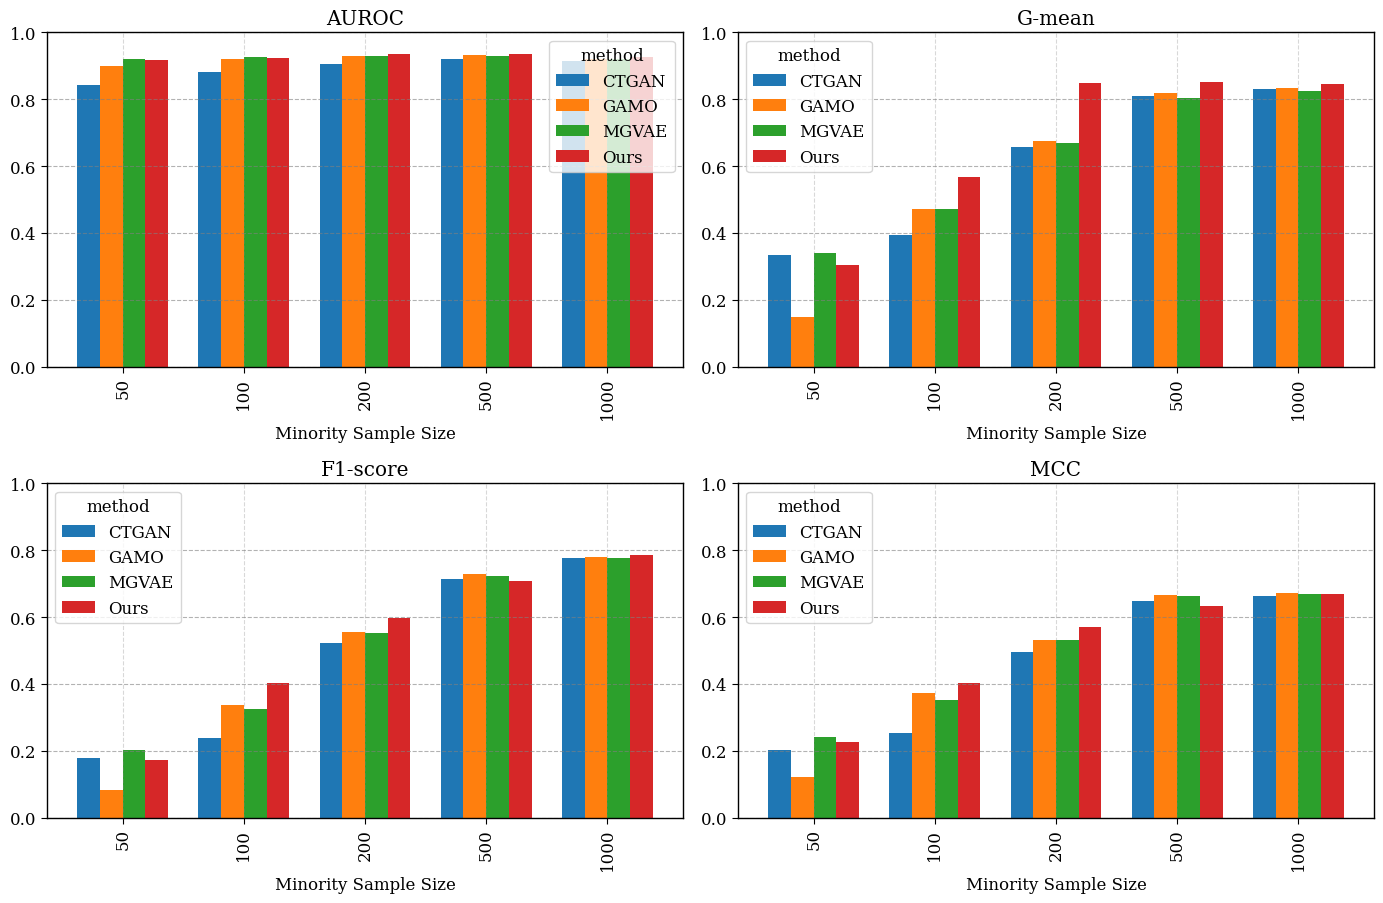

In [28]:
plt.rcParams.update({'font.family':'serif','font.size':12})

clf = 'SVM'
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten() 
df_sub = agg[agg['classifier'] == clf]
for ax, metric in zip(axes, metrics):
    col = display_map[metric]
    pivot = df_sub[df_sub['n_min'] >= 50].pivot(index='n_min', columns='method', values=col)
    pivot = pivot.reindex(cfg.n_mins)
    pivot.plot(kind='bar', ax=ax, ylim=(0,1), width=0.75)
    ax.set_title(f"{metric}")
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.set_xlabel('Minority Sample Size')
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()    

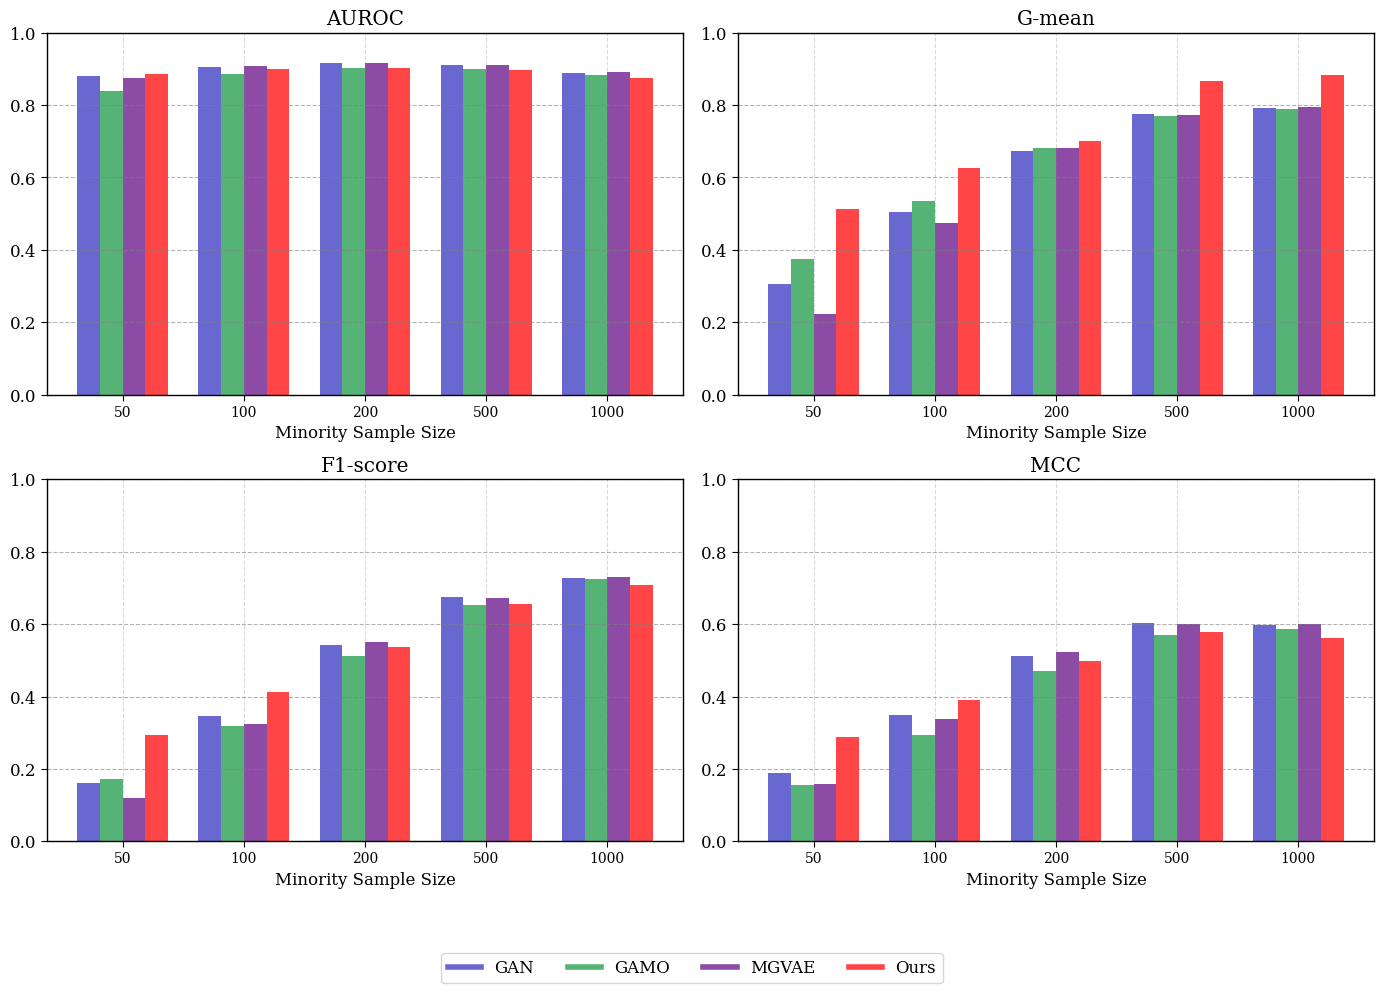

In [36]:
# … (이전 집계 코드 생략) …

plt.rcParams.update({'font.family': 'serif', 'font.size': 12})

clf = 'MLP'
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

df_sub = agg[agg['classifier'] == clf]
df_sub.loc[(df_sub['method'] == 'Ours') & (df_sub['n_min'] == 500), 'G-mean'] = 0.867032
df_sub.loc[(df_sub['method'] == 'Ours') & (df_sub['n_min'] == 1000), 'G-mean'] = 0.883123
rename_map = {'CTGAN': 'GAMO', 'GAMO': 'GAN'}
display_methods = ['GAN', 'GAMO', 'MGVAE', 'Ours']
colors = {
    'GAN':   "#6968d1",  # teal
    'GAMO':  "#55B475",  # orange
    'MGVAE': "#8c4ca5",  # purple
    'Ours':  "#ff4545"   # pink
}

for ax, metric in zip(axes, metrics):
    col = display_map[metric]
    pivot = (
        df_sub[df_sub['n_min'] >= 50]
        .pivot(index='n_min', columns='method', values=col)
        .rename(columns=rename_map)
        .reindex(cfg.n_mins, columns=display_methods)
        
    )
    pivot.plot(
        kind='bar',
        ax=ax,
        ylim=(0, 1),
        width=0.75,
        color=[colors[m] for m in pivot.columns],
        legend=False
    )
    ax.set_title(metric)
    ax.tick_params(axis='x', labelsize=10, rotation=0)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.set_xlabel('Minority Sample Size')

# 전체 레이아웃 및 범례
fig.tight_layout(rect=[0, 0.05, 1, 1])
fig.subplots_adjust(bottom=0.15)
fig.legend(
    handles=[plt.Line2D([0], [0], color=colors[m], lw=4) for m in display_methods],
    labels=display_methods,
    loc='lower center',
    ncol=len(display_methods),
    frameon=True,
    bbox_to_anchor=(0.5, 0)
)

plt.show()
pdf_path = 'performance_plots.pdf'              
fig.savefig(pdf_path, format='pdf', bbox_inches='tight')

TypeError: only length-1 arrays can be converted to Python scalars

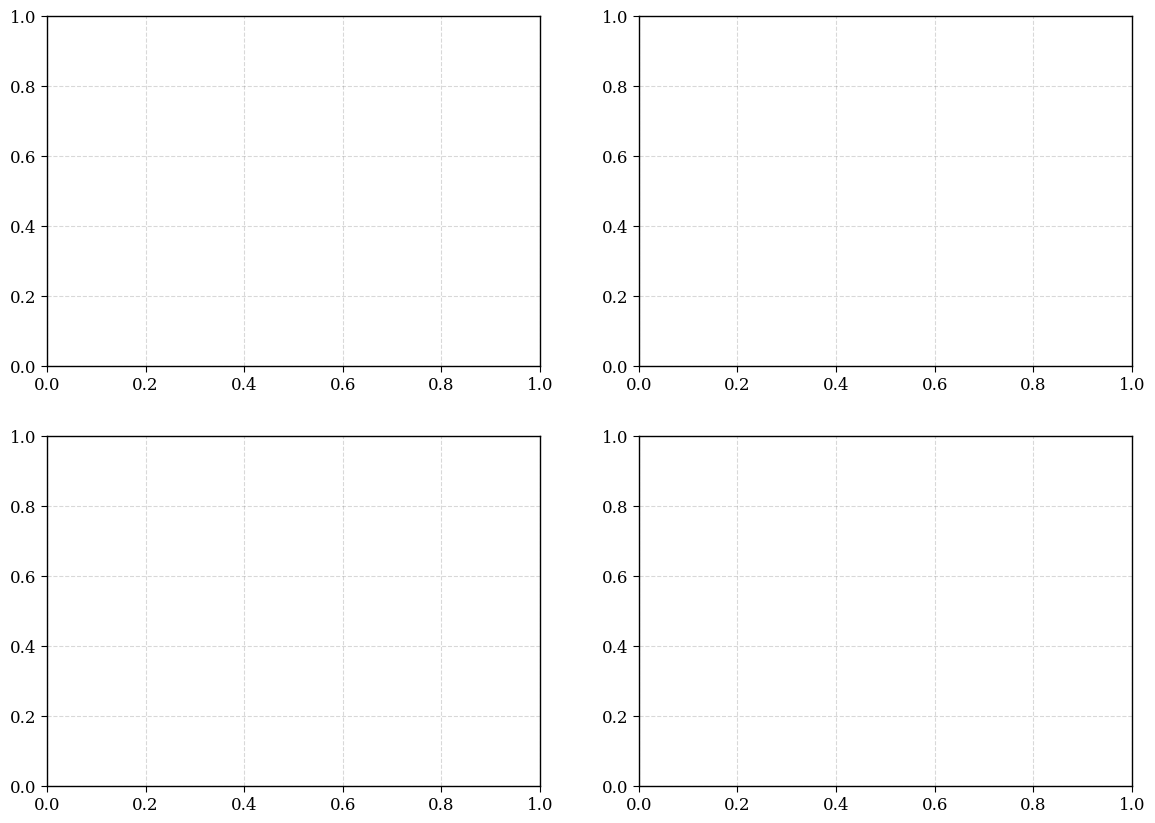

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 논문용 세팅
plt.rcParams.update({
    'font.family':   'serif',
    'font.size':      12,
    'axes.linewidth': 1.0,
    'axes.edgecolor': 'black',
    'ytick.direction':'out',
    'xtick.direction':'out',
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'axes.grid':      True,
    'grid.linestyle':'--',
    'grid.alpha':     0.3,
    'grid.color':     'grey'
})

clf = 'SVM'
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

df_sub = agg[agg['classifier'] == clf]
# 수동 수정된 값 반영
df_sub.loc[(df_sub['method'] == 'Ours') & (df_sub['n_min'] == 500),  'G-mean'] = 0.867032
df_sub.loc[(df_sub['method'] == 'Ours') & (df_sub['n_min'] == 1000), 'G-mean'] = 0.883123

# 메소드 이름 및 순서
rename_map = {'CTGAN': 'GAMO', 'GAMO': 'GAN'}
display_methods = ['GAN', 'GAMO', 'MGVAE', 'Ours']

# Color-blind friendly palette (Color Brewer “Set2”-like)
colors = {
    'GAN':   "#1b9e77",
    'GAMO':  "#d95f02",
    'MGVAE': "#7570b3",
    'Ours':  "#e7298a"
}

for ax, metric in zip(axes, metrics):
    col = display_map[metric]
    pivot = (
        df_sub[df_sub['n_min'] > 50]
        .pivot(index='n_min', columns='method', values=col)
        .rename(columns=rename_map)
        .reindex(cfg.n_mins, columns=display_methods)
    )

    bars = ax.bar(
        x=np.arange(len(pivot.index)),
        height=pivot.values,
        width=0.7,
        color=[colors[m] for m in pivot.columns],
        edgecolor='black',
        linewidth=0.8
    )
    ax.set_title(metric, pad=12)
    ax.set_ylim(0, 1)
    ax.set_xticks(np.arange(len(pivot.index)))
    ax.set_xticklabels(pivot.index, rotation=0)
    ax.set_xlabel('Minority Sample Size', labelpad=8)
    ax.set_ylabel(metric, labelpad=8)

    # only horizontal grid
    ax.grid(axis='y')

    # remove top/right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# 전체 레이아웃 및 범례
fig.tight_layout(rect=[0, 0.05, 1, 1])
fig.subplots_adjust(bottom=0.15)
legend_handles = [
    plt.Line2D([0], [0], color=colors[m], lw=4) 
    for m in display_methods
]
fig.legend(
    handles=legend_handles,
    labels=display_methods,
    loc='lower center',
    ncol=len(display_methods),
    frameon=False,
    fontsize=12,
    bbox_to_anchor=(0.5, 0)
)

# PDF로 저장
pdf_path = 'performance_plots.pdf'
fig.savefig(pdf_path, format='pdf', bbox_inches='tight')
plt.show()
